# 2023-10-06 2D Advection-diffusion and waves

## Last time

* Implicit Runge-Kutta methods
* Exploring/discussing tradeoffs
* SciML benchmarks suite (`DifferentialEquations.jl`)

## Today
* FD methods in 2D
* Cost profile
* The need for fast algebraic solvers
* Wave equation and Hamiltonians
* Symplectic integrators

In [20]:
using Plots
default(linewidth=3)
using LinearAlgebra
using SparseArrays

function my_spy(A)
    cmax = norm(vec(A), Inf)
    s = max(1, ceil(120 / size(A, 1)))
    spy(A, marker=(:square, s), c=:diverging_rainbow_bgymr_45_85_c67_n256, clims=(-cmax, cmax))
end
    
function plot_stability(Rz, title; xlims=(-2, 2), ylims=(-2, 2))
    x = LinRange(xlims[1], xlims[2], 100)
    y = LinRange(ylims[1], ylims[2], 100)
    heatmap(x, y, (x, y) -> abs(Rz(x + 1im*y)), c=:bwr, clims=(0, 2), aspect_ratio=:equal, title=title)
end

struct RKTable
    A::Matrix
    b::Vector
    c::Vector
    function RKTable(A, b)
        s = length(b)
        A = reshape(A, s, s)
        c = vec(sum(A, dims=2))
        new(A, b, c)
    end
end

function rk_stability(z, rk)
    s = length(rk.b)
    1 + z * rk.b' * ((I - z*rk.A) \ ones(s))
end

rk4 = RKTable([0 0 0 0; .5 0 0 0; 0 .5 0 0; 0 0 1 0], [1, 2, 2, 1] / 6)

function ode_rk_explicit(f, u0; tfinal=1., h=0.1, table=rk4)
    u = copy(u0)
    t = 0.
    n, s = length(u), length(table.c)
    fY = zeros(n, s)
    thist = [t]
    uhist = [u0]
    while t < tfinal
        tnext = min(t+h, tfinal)
        h = tnext - t
        for i in 1:s
            ti = t + h * table.c[i]
            Yi = u + h * sum(fY[:,1:i-1] * table.A[i,1:i-1], dims=2)
            fY[:,i] = f(ti, Yi)
        end
        u += h * fY * table.b
        t = tnext
        push!(thist, t)
        push!(uhist, u)
    end
    thist, hcat(uhist...)
end

ode_rk_explicit (generic function with 1 method)

# Extending advection-diffusion to 2D

## 1 dimension

\begin{align} u_t + (- \kappa u_x + w u)_x &= f(x) & \text{ on } \Omega &= (a,b) \\
u(a) &= g_D(a) & u'(b) &= g_N(b) \end{align}

* Cell Peclet number $\mathrm{Pe}_h = \frac{\lvert w \rvert h}{\kappa}$
  * $\mathrm{Pe}_h \lesssim 1$ avoids oscillations
  * $\mathrm{Pe}_h \gtrsim 1$ is non-stiff for time-dependent model
* Centered versus upwind for advection
* Need uniformly bounded $\kappa \ge \epsilon > 0$
* "Strong form" not defined at discontinuities in $\kappa$
  * Works okay using divergence form and fluxes at staggered points

## 2 dimensions

\begin{align} u_t + \nabla\cdot\big(- \kappa \nabla u + \mathbf{w} u \big) &= f(x,y) & \text{ on } \Omega & \subset \mathbb R^2 \\
u|_{\Gamma_D} &= g_D(x,y) \\
(-\kappa \nabla u + \mathbf w u) \cdot \hat n|_{\Gamma_N} &= g_N(x,y)
\end{align}

* $\Omega$ is some well-connected open set (we will assume simply connected) and the Dirichlet boundary $\Gamma_D \subset \partial \Omega$ is nonempty.
* Finite difference methods don't have an elegant/flexible way to specify boundaries
* We'll choose $\Omega = (-1, 1) \times (-1, 1)$

# On finite difference grids

* Non-uniform grids can mesh "special" domains
  * Rare in 3D; overset grids, immersed boundary methods
* Concept of staggering is complicated/ambiguous

<div>
<img src="/files/img/Beckers-B-Grid.png" width="40%" float="left" /> <img src="/files/img/Beckers-C-Grid.png" width="40%" float="right" />
</div>

![Wesseling 11.4: A boundary-fitted grid around an airfoil.](img/Wesseling-Fig11.4-boundary-fitted-grid.png)

# Time-independent advection-diffusion

## Advection

$$ \nabla\cdot(\mathbf w u) = \mathbf w \cdot \nabla u + (\nabla\cdot \mathbf w) u$$

If we choose divergence-free $\mathbf w$, we can use the stencil

$$ \mathbf w \cdot \nabla u \approx \frac 1 h \begin{bmatrix}
& w_2 & \\
-w_1 & & w_1 \\
& -w_2 &
\end{bmatrix} \!:\! \begin{bmatrix}
u_{i-1, j+1} & u_{i, j+1} & u_{i+1,j+1} \\
u_{i-1, j} & u_{i, j} & u_{i+1,j} \\
u_{i-1, j-1} & u_{i, j-1} & u_{i+1,j-1} \\
\end{bmatrix}
$$

# Diffusion

$$ -\nabla\cdot(\kappa \nabla u) = -\kappa \nabla\cdot \nabla u - \nabla\kappa\cdot \nabla u$$
* When would you trust this decomposition?
* If we have constant $\kappa$, we can write
$$
-\kappa \nabla\cdot \nabla u \approx \frac{\kappa}{h^2} \begin{bmatrix}
& -1 & \\
-1 & 4 & -1 \\
& -1 &
\end{bmatrix} \!:\! \begin{bmatrix}
u_{i-1, j+1} & u_{i, j+1} & u_{i+1,j+1} \\
u_{i-1, j} & u_{i, j} & u_{i+1,j} \\
u_{i-1, j-1} & u_{i, j-1} & u_{i+1,j-1} \\
\end{bmatrix}
$$

# Advection-diffusion in code

In [2]:
function advdiff_matrix(n; kappa=1, wind=[1, 1]/sqrt(2))
    h = 2 / n
    rows = Vector{Int64}()
    cols = Vector{Int64}()
    vals = Vector{Float64}()
    idx(i, j) = (i-1)*n + j
    stencil_advect = [-wind[1], -wind[2], 0, wind[1], wind[2]] / h
    stencil_diffuse = [-1, -1, 4, -1, -1] * kappa / h^2
    for i in 1:n
        for j in 1:n
            if i in [1, n] || j in [1, n]
                push!(rows, idx(i, j))
                push!(cols, idx(i, j))
                push!(vals, 1.)
            else
                append!(rows, repeat([idx(i,j)], 5))
                append!(cols, [idx(i-1,j), idx(i,j-1), idx(i,j), idx(i+1,j), idx(i,j+1)])
                append!(vals, stencil_advect + stencil_diffuse)
            end
        end
    end
    sparse(rows, cols, vals)
end

advdiff_matrix (generic function with 1 method)

# Spy the matrix

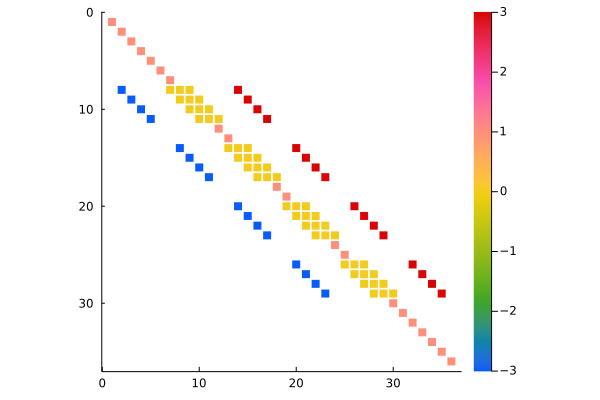

In [39]:
A = advdiff_matrix(6, wind=[1, 0], kappa=.001)
my_spy(A)

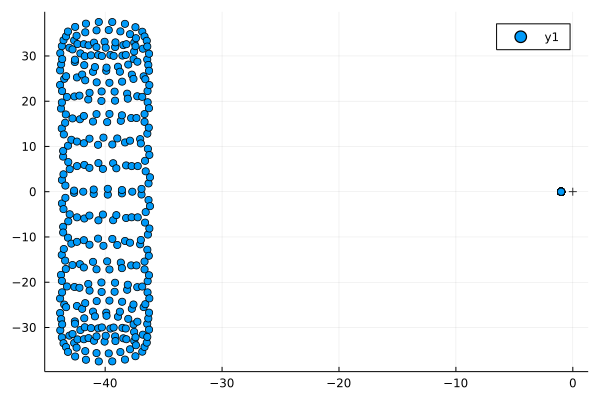

In [56]:
A = advdiff_matrix(20, wind=[2, 1], kappa=.1)
ev = eigvals(Matrix(-A))
scatter(real(ev), imag(ev))
scatter!([0], [0], color=:black, label=:none, marker=:plus)

# Plot a solution

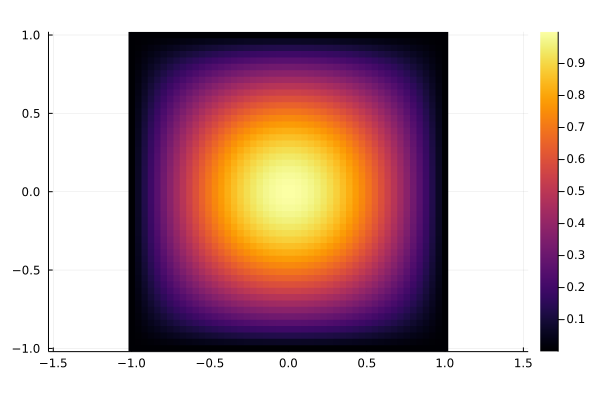

In [68]:
n = 50
x = LinRange(-1, 1, n)
y = x
f = cos.(pi*x/2) * cos.(pi*y/2)'
heatmap(x, y, f, aspect_ratio=:equal)

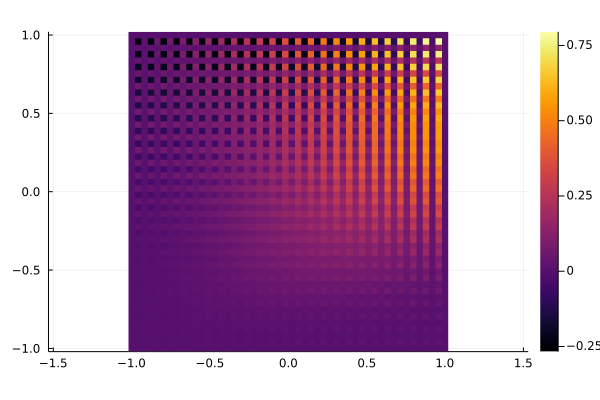

In [69]:
A = advdiff_matrix(n, wind=[2,1], kappa=.001)
u = A \ vec(f)
heatmap(x, y, reshape(u, n, n), aspect_ratio=:equal)

* What happens when advection dominates?
* As you refine the grid?

# Cost breadown and optimization

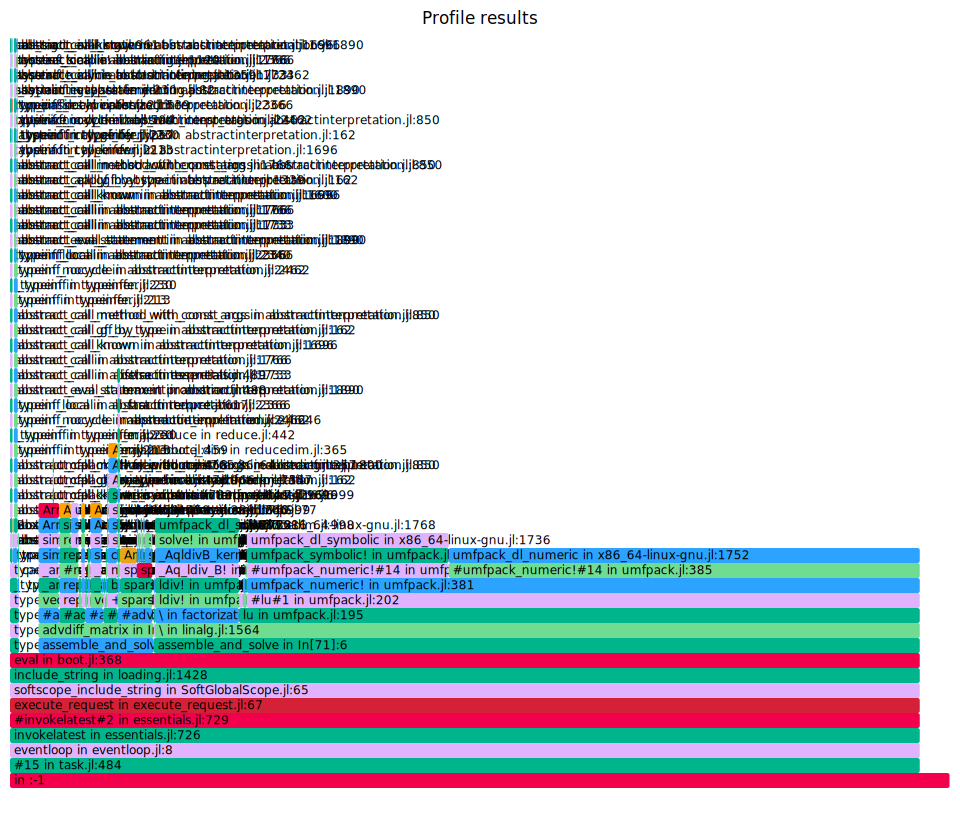

┌ Warning: The depth of this graph is 96, exceeding the `maxdepth` (=50).
│ The deeper frames will be truncated.
└ @ ProfileSVG /home/jed/.julia/packages/ProfileSVG/ecSyU/src/ProfileSVG.jl:275
┌ Warning: The depth of this graph is 96, exceeding the `maxdepth` (=50).
│ The deeper frames will be truncated.
└ @ ProfileSVG /home/jed/.julia/packages/ProfileSVG/ecSyU/src/ProfileSVG.jl:275


In [71]:
using ProfileSVG
function assemble_and_solve(n)
    A = advdiff_matrix(n)
    x = LinRange(-1, 1, n)
    f = cos.(pi*x/2) * cos.(pi*x/2)'
    u = A \ vec(f)
end

@profview assemble_and_solve(400)

# What's left?

* Symmetric Dirichlet boundary conditions
* Symmetric Neumann boundary conditions
* Verification with method of manufactured solutions
* Non-uniform grids
* Upwinding for advection-dominated problems
* Variable coefficients
* Time-dependent problems
* Fast algebraic solvers

# Gas equations of state

There are many ways to describe a gas

| Name | variable | units |
|------|----------|-------|
| pressure | $p$ | force/area |
| density | $\rho$ | mass/volume |
| temperature | $T$ | Kelvin |
| (specific) internal energy | $e$ | energy/mass |
| entropy | $s$ | energy/Kelvin |

## Equation of state

$$ \rho, e \mapsto p, T $$

## Ideal gas

\begin{align} p &= \rho R T & e &= e(T)
\end{align}
$$ p = (\gamma - 1) \rho e $$

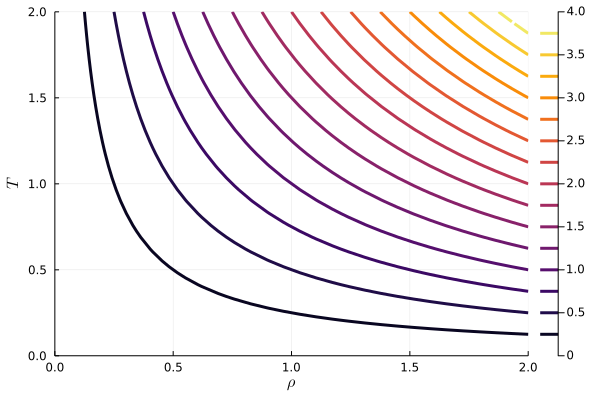

In [21]:
pressure(rho, T) = rho*T

contour(LinRange(0, 2, 30), LinRange(0, 2, 30), pressure, xlabel="\$\\rho\$", ylabel="\$T\$")

# Conservation equations

## Mass

Let $\mathbf u$ be the fluid velocity. The mass flux (mass/time) moving through an area $A$ is

$$ \int_A \rho \mathbf u \cdot \hat{\mathbf n} .$$

If mass is conserved in a volume $V$ with surface $A$, then the total mass inside the volume must evolve as

$$ \int_V \rho_t = \left( \int_V \rho \right)_t = - \underbrace{\int_A \rho\mathbf u \cdot \hat{\mathbf n}}_{\int_V \nabla\cdot (\rho\mathbf u)},$$
where we have applied the divergence theorem. Dropping the integrals over arbitrary volumes, we have the evolution equation for conservation of mass.
$$ \rho_t + \nabla\cdot (\rho \mathbf u) = 0 $$

## Momentum

The momentum $\rho \mathbf u$ has a flux that includes

* convection $\rho \mathbf u \otimes \mathbf u$
  * this is saying that each component of momentum is carried along in the vector velocity field
* pressure $p I$
* viscous $-\boldsymbol\tau$

A similar integral principle leads to the momentum equation

$$ (\rho \mathbf u)_t + \nabla\cdot\big[ \rho \mathbf u \otimes \mathbf u + p I - \boldsymbol \tau \big] = 0 $$